### 1. Load Data

In [0]:
import pandas as pd
import numpy as np
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [0]:
import pyspark.pandas as ps

entries = spark.table("workspace.default.entries").toPandas()
funnel_events = spark.table("workspace.default.funnel_events").toPandas()
product_purchases = spark.table("workspace.default.product_purchases").toPandas()

### 2. Get familiar with the data to prepare them for preprocessing

#### 2.1 entries/ads/job listings

In [0]:
# job listings
entries.head(3)

,job_specialty,revision,entry_created_at,entry_updated_at,educational_level,job_type,work_experience,salary,specialty_group_name,entry_id
0,DISH_WASHERS,1,2025-02-03 16:28:12.979,2025-02-03 16:28:12.979,null,"[""FULL_TIME""]",null,"{""salary_hidden"":""false"",""salary_max_amount"":""...",FOOD_BEVERAGE,4e9fa212-f9cb-4c0f-b753-e81c9517aafa
1,OTHER_SPECIALTIES,1,2024-09-07 10:23:57.784,2024-09-07 10:23:57.784,null,"[""FULL_TIME""]",null,"{""salary_hidden"":""true"",""salary_max_amount"":""5...",OTHER,81227a45-a20d-4456-924f-fc941cf2a3c5
2,KINDERGARTEN_TEACHERS,6,2024-07-01 11:49:08.630,2024-08-28 17:52:45.849,null,"[""PERMANENT""]",null,"{""salary_hidden"":""true"",""salary_max_amount"":""1...",EDUCATION,5d25c230-5bec-411e-83fd-91a1e59c84e4


In [0]:
entries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168014 entries, 0 to 168013
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   job_specialty         168014 non-null  object        
 1   revision              168014 non-null  int64         
 2   entry_created_at      168014 non-null  datetime64[ns]
 3   entry_updated_at      168014 non-null  datetime64[ns]
 4   educational_level     168014 non-null  object        
 5   job_type              168014 non-null  object        
 6   work_experience       168014 non-null  object        
 7   salary                168014 non-null  object        
 8   specialty_group_name  168014 non-null  object        
 9   entry_id              168014 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 12.8+ MB


In [0]:
entries.salary[0],entries.salary[1]

('{"salary_hidden":"false","salary_max_amount":"1000.0","salary_min_amount":"1000.0","salary_rate":"MONTHLY","salary_type":"EXACT"}',
 '{"salary_hidden":"true","salary_max_amount":"500.0","salary_min_amount":"500.0","salary_rate":"MONTHLY","salary_type":"STARTING_FROM"}')

In [0]:
json.loads(entries.salary[0]).get('salary_hidden')

'false'

In [0]:
# This should return only <class 'str'>
print(entries['job_specialty'].map(type).value_counts())

<class 'str'>    168014
Name: job_specialty, dtype: int64


In [0]:
# ensure every job_specialty value is string (should return 168014 = entries.shape[0])
print(entries['job_specialty'].map(type).value_counts())
entries.job_specialty.unique()[:5]

<class 'str'>    168014
Name: job_specialty, dtype: int64


array(['DISH_WASHERS', 'OTHER_SPECIALTIES', 'KINDERGARTEN_TEACHERS',
       'COOKS_CHEFS', 'CLEANERS'], dtype=object)

In [0]:
# no typos, only correct dtype (and null entries??)
entries.educational_level.unique()

array(['null', 'NO_PREFERENCE', 'HIGH_SCHOOL', 'PRIMARY_SCHOOL',
       'POST_SECONDARY_EDUCATION', 'BACHELOR', 'MASTER', 'PHD'],
      dtype=object)

In [0]:
# str(list)!! ensure each element of list is str
entries.job_type.unique()

array(['["FULL_TIME"]', '["PERMANENT"]', '["PART_TIME"]',
       '["FULL_TIME","PART_TIME"]', '["FULL_TIME","PERMANENT"]',
       '["UNDEFINED"]', '["FULL_TIME","PART_TIME","PERMANENT"]',
       '["PART_TIME","FULL_TIME"]', '["FULL_TIME","FIXED_TERM_CONTRACT"]',
       '["PART_TIME","PERMANENT","FIXED_TERM_CONTRACT","TEMPORARY_CONTRACT"]',
       '["INTERNSHIP"]', '["PART_TIME","PERMANENT"]',
       '["FULL_TIME","PERMANENT","PART_TIME"]',
       '["PERMANENT","FULL_TIME","PART_TIME"]',
       '["PART_TIME","FIXED_TERM_CONTRACT"]',
       '["PART_TIME","PERMANENT","FULL_TIME"]', '["FIXED_TERM_CONTRACT"]',
       '["TEMPORARY_CONTRACT"]',
       '["FULL_TIME","PART_TIME","PERMANENT","TEMPORARY_CONTRACT","FIXED_TERM_CONTRACT","INTERNSHIP"]',
       '["PERMANENT","FULL_TIME"]', '["FULL_TIME","UNDEFINED"]',
       '["FULL_TIME","TEMPORARY_CONTRACT"]', '["PERMANENT","PART_TIME"]',
       '["FULL_TIME","INTERNSHIP"]',
       '["FIXED_TERM_CONTRACT","PART_TIME"]',
       '["UNDEFINED","FULL_T

In [0]:
# null entries and correct dtype
entries.work_experience.unique()

array(['null', 'NO_PRIOR_WORK_EXPERIENCE_REQUIRED', '2-3_YEARS',
       '3-5_YEARS', '1-2_YEARS', 'LESS_THAN_1_YEAR', '10+_YEARS',
       '5-10_YEARS'], dtype=object)

In [0]:
# no typos, everything looks ok
np.sort(entries.specialty_group_name.unique())

array(['AGRICULTURE_FISHING', 'ARTS_MEDIA_PUBLISHING', 'BEAUTY_SERVICES',
       'EDUCATION', 'FASHION_CLOTHING_FOOTWEAR', 'FOOD_BEVERAGE',
       'HEALTHCARE_SERVICES', 'HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT',
       'IT', 'MANAGEMENT_BUSINESS_MARKETING',
       'OFFICE_SUPPORT_CUSTOMER_SERVICE_ACCOUNTING', 'OTHER', 'RETAIL',
       'SCIENCE_RESEARCH', 'SHIPPING_MARITIME',
       'SPORTS_OUTDOOR_ACTIVITIES', 'TECHNICIANS_LABORERS', 'TOURISM',
       'TRANSPORTATION_LOGISTICS'], dtype=object)

In [0]:
# no typos, only correct the dtype
np.sort(entries.job_specialty.unique())

array(['ACTORS_DANCERS', 'AGRICULTURAL_ENGINEERS',
       'AGRONOMISTS_SURVEYORS', 'AIRCRAFT_TECHNICIANS',
       'ALTERNATIVE_HEALERS', 'AMBULANCE_SERVICES', 'ARCHAEOLOGISTS',
       'ARCHITECTS', 'ART_CONSERVATION_AND_RESTORATION',
       'ASSISTANT_COOKS_SOUS_CHEFS', 'AUDIT_ACCOUNTING',
       'AUTOMOTIVE_ELECTRICIANS', 'AUTOMOTIVE_TECHNICIANS',
       'AUTO_BODY_TECHNICIANS', 'AWNING_INSTALLERS', 'BABY_SITTERS',
       'BAKERS', 'BANK_EMPLOYEES', 'BARISTAS', 'BARTENDERS',
       'BEAUTICIANS', 'BINDERY_ASSISTANTS',
       'BIOCHEMISTS_BIOLOGISTS_BIOTECHNOLOGISTS', 'BIOLOGY_TEACHERS',
       'BLACKSMITHS', 'BOAT_CAPTAINS_DECK_OFFICERS',
       'BREWERS_OENOLOGISTS_VINTNERS', 'BUFFET_ATTENDANTS', 'BUILDERS',
       'BURNER_TECHNICIANS', 'BUTCHERS', 'CABIN_CREW_MEMBERS',
       'CALL_CENTER_CLIENT_SERVICE',
       'CARPENTERS_FURNITURE_MAKERS_UPHOLSTERERS', 'CAR_MECHANICS',
       'CASHIERS', 'CATERING', 'CHEMICAL_ENGINEERS', 'CHEMISTRY_TEACHERS',
       'CHILD_ADOLESCENT_PSYCHIATRIST

In [0]:
entries.entry_id.nunique()

26397

#### 2.2 funnel events

In [0]:
funnel_events.head(3)

,event_date,event_name,created_at,entry_revision,domain_version,entry_id,visitor_id
0,2025-02-17,listing_details_page_view,2025-02-17 15:11:49.986268,31,9,9e13db9c-84b1-47c9-890e-be960e006067,1b023023-cf72-4024-8b25-3428ad490dee
1,2025-03-25,listing_details_page_view,2025-03-25 21:34:15.473035,3,9,4362d174-d1fe-4562-b545-9bc10ebdf623,33c37a8b-3b7a-4e85-a852-1fa84d1f01fb
2,2025-02-21,listing_details_page_view,2025-02-21 01:01:55.992580,2,9,ce305ae0-7eb8-44df-875e-78a600951067,5835ca7b-9e0c-4fc1-a50a-feb91049585c


In [0]:
funnel_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937190 entries, 0 to 937189
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_date      937190 non-null  object        
 1   event_name      937190 non-null  object        
 2   created_at      937190 non-null  datetime64[ns]
 3   entry_revision  937190 non-null  int64         
 4   domain_version  937190 non-null  int64         
 5   entry_id        937190 non-null  object        
 6   visitor_id      937190 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 50.1+ MB


In [0]:
funnel_events.entry_id.nunique()

26358

In [0]:
funnel_events.visitor_id.nunique()

488006

In [0]:
funnel_events.event_name.unique()

array(['listing_details_page_view', 'listing_message_form_interaction',
       'listing_phoneview'], dtype=object)

#### 2.3 product purchases

In [0]:
product_purchases.head(3)

,product,entry_id
0,απλή 30 ημερών,728f5dd3-a9f3-4609-9063-f97607e57160
1,απλή 14 ημερών,7bf67a99-9ef2-4f80-ab1e-031ad7839d30
2,απλή 30 ημερών,cdad9339-ce44-4a75-a08c-87b520a5a2ba


In [0]:
product_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31305 entries, 0 to 31304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   product   31305 non-null  object
 1   entry_id  31305 non-null  object
dtypes: object(2)
memory usage: 489.3+ KB


In [0]:
product_purchases.entry_id.nunique()

26346

In [0]:
product_purchases.entry_id.nunique() == funnel_events.entry_id.nunique()

False

In [0]:
# ????? maybe there are product events that never leaded in purchases..

In [0]:
np.sort(product_purchases['product'].unique())

array(['elite 30 ημερών', 'plus 30 ημερών', 'superior 14 ημερών',
       'ultimate 14 ημερών', 'ultimate 30 ημερών',
       'ultimate social 30 ημερών', 'ultimate social inbound 30 ημερών',
       'απλή 14 ημερών', 'απλή 30 ημερών'], dtype=object)

#### Findings/Notes

__entries/ads/job listings:__
- __entry_created_at__, __entry_updated_at__, convert to __datetime__   __[DONE]__
- __job_type__ is a string(list of strings), convert to actual list (and use explode() in EDA ?? otherwise create new entries per value) __[DONE]__
- __salary__ has JSON format, extract the 'new' attribures + check for null values on them + ocnvert them to correct dtypes __[DONE]__
- __work_experience__ has null entries , assign them to NO_PRIOR_WORK_EXPERIENCE_REQUIRED __[DONE]__
   - __Note:__ convert null values to EMPTY is also a safe option (there might be job listings that only specify highly experienced) 
- __educational_level__ has null entries and since NO_PREFERENCE is already a value i will assign them to this value __[DONE]__
- correct every column type __[DONE]__
- __entry_created_at__, __entry_updated_at__ extract new columns of year/month/day of the week?????

As for __funnel_events__ and __product_purchases__, I'll only correct their column types.

### 3. Preprocessing and Type Conversion

#### 3.1 entries preprocessing and feature extraction

In [0]:
def parse_job_type(value):
    try:
        # Convert string of list to list
        parsed = ast.literal_eval(value)        
        # Ensure that all elements of the list are strings
        if isinstance(parsed, list) and all(isinstance(item, str) for item in parsed):
            return parsed
        else:
            raise ValueError(f"Invalid format: {parsed}")
    except Exception as e:
        raise ValueError(f"Failed to parse job_type:{e}")


In [0]:
# job_type from string of list to list
entries['job_type'] = entries['job_type'].apply(parse_job_type)

# correct null entries for educational_level/work_experience
entries['educational_level'] = entries['educational_level'].replace('null', 'NO_PREFERENCE')
entries['work_experience'] = entries['work_experience'].replace('null', 'NO_PRIOR_WORK_EXPERIENCE_REQUIRED')

# extract salary (JSON) columns     alternatives: https://datascientyst.com/normalize-json-dict-new-columns-pandas/
parsed_salary = entries.salary.apply(lambda x: (json.loads(x))) # Series
salary_df = pd.json_normalize(parsed_salary) # Series to DF
entries = pd.concat([entries.drop(columns=['salary']), salary_df], axis=1)

In [0]:
entries.salary_hidden.unique()

array(['false', 'true'], dtype=object)

In [0]:
entries.salary_rate.unique()

array(['MONTHLY', 'HOURLY', 'WEEKLY', 'DAILY', 'YEARLY'], dtype=object)

In [0]:
entries.salary_type.unique()

array(['EXACT', 'STARTING_FROM', 'RANGE'], dtype=object)

#### 3.2 Type Conversion of entries/funnel_events/product_purchases

In [0]:
# correct the types of each column

# [1] entries
entries['entry_created_at'] = pd.to_datetime(entries['entry_created_at'])
entries['entry_updated_at'] = pd.to_datetime(entries['entry_updated_at'])

entries.job_specialty = entries.job_specialty.astype(str)
entries.educational_level = entries.educational_level.astype(str)
entries.work_experience = entries.work_experience.astype(str)
entries.specialty_group_name = entries.specialty_group_name.astype(str)
entries.entry_id = entries.entry_id.astype(str)

entries.salary_hidden = entries.salary_hidden.map({'true': True, 'false': False})
entries.salary_max_amount = entries.salary_max_amount.astype(float)
entries.salary_min_amount = entries.salary_min_amount.astype(float)
entries.salary_rate = entries.salary_rate.astype(str)
entries.salary_type = entries.salary_type.astype(str)

# [2] funnel_events
funnel_events['event_date'] = pd.to_datetime(funnel_events['event_date'])
funnel_events['created_at'] = pd.to_datetime(funnel_events['created_at'])
funnel_events.entry_id = funnel_events.entry_id.astype(str)
funnel_events.visitor_id = funnel_events.visitor_id.astype(str)
funnel_events.event_name = funnel_events.event_name.astype(str)

# [3] product_purchases
product_purchases.entry_id = product_purchases.entry_id.astype(str)
product_purchases['product'] = product_purchases['product'].astype(str)

I'll keep the __job_type__ as list of string and use explode().

In [0]:
entries_exploded = entries.explode('job_type')

In [0]:
entries_exploded_sdf = spark.createDataFrame(entries_exploded)
funnel_events_sdf = spark.createDataFrame(funnel_events)
product_purchases_sdf = spark.createDataFrame(product_purchases)

entries_exploded_sdf.createOrReplaceTempView("entries_exploded")
funnel_events_sdf.createOrReplaceTempView("funnel_events")
product_purchases_sdf.createOrReplaceTempView("product_purchases")

### 4. Data Cleansing

- Check for duplicate entries.
- Identify error values in numeric columns, such as:
  - Salaries below the legal minimum (e.g., the minimum gross monthly salary in Greece is €880).
  - Potential typos or suspicious values (e.g., monthly salaries above €10,000 which is extremelly rare in Greece).

Non-numeric columns were validated in previous sections.

#### 4.1 entries

__a)__ Check for duplicates

In [0]:
duplicates = entries_exploded.duplicated()
duplicates.value_counts()

False    226367
True          6
dtype: int64

In [0]:
duplicate_entries = entries_exploded[entries_exploded.duplicated(keep=False)]
duplicate_entries

,job_specialty,revision,entry_created_at,entry_updated_at,educational_level,job_type,work_experience,specialty_group_name,entry_id,salary_hidden,salary_max_amount,salary_min_amount,salary_rate,salary_type
37399,CLEANERS,9,2023-03-22 08:38:11.000,2024-06-23 17:52:06.100,HIGH_SCHOOL,FULL_TIME,1-2_YEARS,HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,84e0897f-4599-4c1a-81dc-852b9fdffe7b,False,1100.0,1100.0,MONTHLY,EXACT
37399,CLEANERS,9,2023-03-22 08:38:11.000,2024-06-23 17:52:06.100,HIGH_SCHOOL,PERMANENT,1-2_YEARS,HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,84e0897f-4599-4c1a-81dc-852b9fdffe7b,False,1100.0,1100.0,MONTHLY,EXACT
37400,CLEANERS,9,2023-03-22 08:38:11.000,2024-06-23 17:52:06.100,HIGH_SCHOOL,FULL_TIME,1-2_YEARS,HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,84e0897f-4599-4c1a-81dc-852b9fdffe7b,False,1100.0,1100.0,MONTHLY,EXACT
37400,CLEANERS,9,2023-03-22 08:38:11.000,2024-06-23 17:52:06.100,HIGH_SCHOOL,PERMANENT,1-2_YEARS,HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,84e0897f-4599-4c1a-81dc-852b9fdffe7b,False,1100.0,1100.0,MONTHLY,EXACT
44103,CAR_MECHANICS,9,2019-07-16 15:34:52.000,2024-10-27 19:16:07.065,POST_SECONDARY_EDUCATION,FULL_TIME,2-3_YEARS,TECHNICIANS_LABORERS,3755bedb-bb4a-454b-9054-27bb2a23acb7,True,0.0,0.0,MONTHLY,EXACT
44104,CAR_MECHANICS,9,2019-07-16 15:34:52.000,2024-10-27 19:16:07.065,POST_SECONDARY_EDUCATION,FULL_TIME,2-3_YEARS,TECHNICIANS_LABORERS,3755bedb-bb4a-454b-9054-27bb2a23acb7,True,0.0,0.0,MONTHLY,EXACT
47163,DELIVERY_DRIVERS,18,2024-05-24 16:34:05.000,2024-08-29 15:51:21.788,NO_PREFERENCE,PERMANENT,NO_PRIOR_WORK_EXPERIENCE_REQUIRED,FOOD_BEVERAGE,26d74e04-5362-4b9b-bf4c-d07ca5a4db57,True,5.0,5.0,HOURLY,EXACT
47163,DELIVERY_DRIVERS,18,2024-05-24 16:34:05.000,2024-08-29 15:51:21.788,NO_PREFERENCE,FULL_TIME,NO_PRIOR_WORK_EXPERIENCE_REQUIRED,FOOD_BEVERAGE,26d74e04-5362-4b9b-bf4c-d07ca5a4db57,True,5.0,5.0,HOURLY,EXACT
47164,DELIVERY_DRIVERS,18,2024-05-24 16:34:05.000,2024-08-29 15:51:21.788,NO_PREFERENCE,PERMANENT,NO_PRIOR_WORK_EXPERIENCE_REQUIRED,FOOD_BEVERAGE,26d74e04-5362-4b9b-bf4c-d07ca5a4db57,True,5.0,5.0,HOURLY,EXACT
47164,DELIVERY_DRIVERS,18,2024-05-24 16:34:05.000,2024-08-29 15:51:21.788,NO_PREFERENCE,FULL_TIME,NO_PRIOR_WORK_EXPERIENCE_REQUIRED,FOOD_BEVERAGE,26d74e04-5362-4b9b-bf4c-d07ca5a4db57,True,5.0,5.0,HOURLY,EXACT


They are true duplicates, so I'll drop them.

In [0]:
entries_exploded = entries_exploded.drop_duplicates()

#### Check the overall statistics of numeric columns to identify potential error values

__a)__ Description of numeric attribures.

In [0]:
numeric_cols = ['salary_min_amount', 'salary_max_amount', 'revision']
entries_exploded[numeric_cols].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
salary_min_amount,226367.0,1.325282e+23,3.640426e+25,0.0,0.0,6.0,900.0,1.000000e+28
salary_max_amount,226367.0,1.325282e+23,3.640426e+25,0.0,0.0,6.0,1000.0,1.000000e+28
revision,226367.0,7.800000e+00,2.370000e+01,1.0,2.0,4.0,8.0,5.820000e+02


There are error values on salary_max_amount, salary_min_amount.

__b)__ Potential error entries where salary_max_amount < salary_min_amount

In [0]:
entries_exploded[entries_exploded.salary_max_amount < entries_exploded.salary_min_amount].shape[0]

0

__c)__ entries with yearly, monthly or weekly salary < 10

In [0]:
%sql
SELECT COUNT(DISTINCT entry_id)
FROM entries_exploded
WHERE salary_max_amount < 10
  AND salary_rate NOT IN ('DAILY', 'HOURLY')

COUNT(DISTINCTentry_id)
12572


__d)__ number of entries/job listings that are potentialy fake. 

In [0]:
%sql
SELECT COUNT(DISTINCT entry_id) 
FROM entries_exploded
WHERE 
    (salary_max_amount > 500 AND salary_rate IN ('DAILY', 'HOURLY'))
    OR
    (salary_max_amount > 2000 AND salary_rate = 'WEEKLY')
    OR
    (salary_max_amount > 10000 AND salary_rate = 'MONTHLY')
    OR
    (salary_max_amount > 100000 AND salary_rate = 'YEARLY')


COUNT(DISTINCTentry_id)
158


In [0]:
%sql
WITH latest_entries AS (
  SELECT *
  FROM (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY entry_id ORDER BY revision DESC) AS rn
    FROM entries_exploded
  )
)
SELECT COUNT(DISTINCT entry_id)
FROM latest_entries
WHERE rn = 1
  AND (
    (salary_max_amount > 500 AND salary_rate IN ('DAILY', 'HOURLY'))
    OR (salary_max_amount > 2000 AND salary_rate = 'WEEKLY')
    OR (salary_max_amount > 10000 AND salary_rate = 'MONTHLY')
    OR (salary_max_amount > 100000 AND salary_rate = 'YEARLY')
  )

COUNT(DISTINCTentry_id)
121


The two queries return different counts because:
- One includes all revisions of job listings.
- The other only checks the latest version of each listing.

Some old versions with unusual salary values were fixed later, so they don’t appear in the final filtered result.

#### 4.2 funnel events and product purchases (check for duplicates)

In [0]:
duplicates = funnel_events.duplicated()
duplicates.value_counts()

False    937190
dtype: int64

In [0]:
duplicates = product_purchases.duplicated()
duplicates.value_counts()

False    31305
dtype: int64

__Findings/Notes:__
- There are definitely some job listings with erroneous salary values (extremely high or low).
- Some of these errors are corrected in later revisions.

__Note:__ I’ll keep all entries for now, and apply __approximate filters__ to exclude outliers/error/misleading job listings __only in exercises that involve salary calculations__.


### 5. Job Market Analysis

#### Question 1
Visualize the distribution of page views per ad for RETAIL and
HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT group specialties and report the average,
median, 90% percentile and maximum per group specialty. Which group appears to be more
popular?

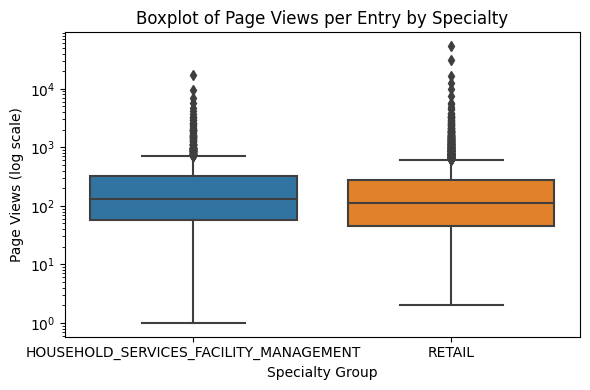

In [0]:
# Filter target specialties
target_specialties = ['RETAIL', 'HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT']
filtered_entries = entries[entries['specialty_group_name'].isin(target_specialties)]

# Filter funnel events to only page views
page_views = funnel_events[funnel_events['event_name'] == 'listing_details_page_view']

# Merge on entry_id
merged = page_views.merge(filtered_entries[['entry_id', 'specialty_group_name']], on='entry_id')

# Count page views per entry
views_per_entry = merged.groupby(['entry_id', 'specialty_group_name']).size().reset_index(name='views')

# Group by specialty and calculate stats
group_stats = views_per_entry.groupby('specialty_group_name')['views'].agg(
    average='mean',
    median='median',
    percentile_90=lambda x: x.quantile(0.9),
    max='max'
).reset_index()

# Plot log boxplots (similar to distributions)

plt.figure(figsize=(6, 4))
sns.boxplot(data=views_per_entry, x="specialty_group_name", y="views")
plt.yscale("log")  # log-scale y-axis
plt.title("Boxplot of Page Views per Entry by Specialty")
plt.ylabel("Page Views (log scale)")
plt.xlabel("Specialty Group")
plt.tight_layout()
plt.show()


In [0]:
# Display aggregations report
display(group_stats.round())

specialty_group_name,average,median,percentile_90,max
HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,303.0,132.0,690.0,16960
RETAIL,295.0,111.0,628.0,53544


__Observations:__ \
__HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT__ has higher average, median, and 90th percentile view counts, along with a smaller standard deviation (as indicated by the tighter boxplot).

__RETAIL__ has a much higher maximum, suggesting the presence of more extreme outliers (it has more 'popular' job listings). However, both groups contain outliers, that's why I used a log transformation and boxplot instead of a histogram.

Based on this, __HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT__ appears to be more __popular__.

In [0]:
# Total views per entry
total_views = merged.groupby(['entry_id', 'specialty_group_name']).size().reset_index(name='total_views')

# Unique views per entry (distinct visitors)
unique_views = merged.groupby(['entry_id', 'specialty_group_name'])['visitor_id'].nunique().reset_index(name='unique_visitor_views')

# Merge both at entry level
views_per_entry = total_views.merge(unique_views, on=['entry_id', 'specialty_group_name'])

# Aggregate total + unique views per group
views_summary = views_per_entry.groupby('specialty_group_name')[
    ['total_views', 'unique_visitor_views']
].sum().reset_index()

# Add number of distinct ads viewed per group
viewed_entries = merged.groupby('specialty_group_name')['entry_id'].nunique().reset_index(name='distinct_entries_viewed')

# Merge cleanly
views_summary = views_summary.merge(viewed_entries, on='specialty_group_name')

# Display
display(views_summary)

specialty_group_name,total_views,unique_visitor_views,distinct_entries_viewed
HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,440158,59992,1451
RETAIL,970075,116486,3287


__Note (!!!):__ 

Although per-listing engagement was higher for HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT, the __total number of views__ and __number of distinct viewed ads__ suggest that __RETAIL__ is the more __popular group__ overall.


#### Question 2
For the most frequent job specialty in terms of number of distinct ads, how is the educational
level distributed and what is the average salary when salary_rate is MONTHLY or DAILY and the
salary_type is EXACT? Use the latest entry revision of each ad.


In [0]:
%sql
WITH latest_entries AS (
  SELECT *
  FROM (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY entry_id ORDER BY revision DESC) AS rn
    FROM entries_exploded
  )
  WHERE rn = 1
)

SELECT educational_level, COUNT(DISTINCT entry_id) AS num_ads
FROM latest_entries
WHERE specialty_group_name = 'RETAIL'
GROUP BY educational_level
ORDER BY num_ads DESC;

educational_level,num_ads
NO_PREFERENCE,1982
HIGH_SCHOOL,834
POST_SECONDARY_EDUCATION,145
BACHELOR,12
PRIMARY_SCHOOL,7
MASTER,2


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

For the average daily and montlhy salaries I'll filter out mistakes/error values.

In [0]:
%sql
WITH latest_entries AS (
  SELECT *
  FROM (
    SELECT *, 
           ROW_NUMBER() OVER (PARTITION BY entry_id ORDER BY revision DESC) AS rn
    FROM entries_exploded
  )
  WHERE rn = 1
)

SELECT salary_rate, ROUND(AVG(salary_max_amount)) AS avg_salary
FROM latest_entries
WHERE 
  specialty_group_name = 'RETAIL'
  AND salary_type = 'EXACT'
  AND (
    (salary_rate = 'DAILY' AND salary_max_amount BETWEEN 2 AND 500) --minimum daily in Greece should be close to 35 euros (4 euros/hour) but I chose a safer option of 2 to not exclude part-time jobs with 2-4 working hour per day
    OR
    (salary_rate = 'MONTHLY' AND salary_max_amount BETWEEN 100 AND 10000) -- minimum monthly in Greece is 880, I choose 100 to not exclude part-time jobs
  )
GROUP BY salary_rate


salary_rate,avg_salary
DAILY,43.0
MONTHLY,974.0


__Observations:__ \
From the pie chart, we notice that __99%__ of the __RETAIL__ job listings require either a __high school education or below__, or have __no preference__ for educational level.

The average daily and monthly salaries of the __RETAIL__ job listings are sligthly above Greece's minimum.

#### Question 3
How many distinct users view ads per day? What is the average number of distinct visitors per
day? Can you explain any extreme lows?


In [0]:
%sql
SELECT DATE(event_date) AS date, COUNT(*) AS total_ad_views, COUNT(DISTINCT visitor_id) as distinct_visitors
FROM funnel_events 
WHERE event_name = 'listing_details_page_view'
GROUP BY DATE(event_date)
ORDER BY date


date,total_ad_views,distinct_visitors
2025-02-01,8428,6703
2025-02-02,9303,7462
2025-02-03,13119,9777
2025-02-04,13393,10003
2025-02-05,12894,9658
2025-02-06,12185,9254
2025-02-07,10581,8071
2025-02-08,8142,6398
2025-02-09,8779,6977
2025-02-10,13120,9725


Databricks visualization. Run in Databricks to view.

Calculate the weekly seasonality

In [0]:
%sql
SELECT 
     YEAR(event_date) AS year, 
     WEEKOFYEAR(event_date) AS week_number,
     COUNT(*) AS total_ad_views,
     COUNT(DISTINCT visitor_id) AS distinct_visitors
FROM funnel_events
WHERE event_name = 'listing_details_page_view'
GROUP BY year, week_number
ORDER BY year, week_number;

year,week_number,total_ad_views,distinct_visitors
2025,5,17731,13809
2025,6,79093,51788
2025,7,74616,48977
2025,8,75871,50467
2025,9,66314,45659
2025,10,75971,51404
2025,11,81675,54184
2025,12,76056,50717
2025,13,68934,46769
2025,14,75486,51821


Databricks visualization. Run in Databricks to view.

__Observations:__ \
There is a clear __weekly seasonality__ with lower activity on weekends and peaks during weekdays.

A major drop occurred on __April 19–20__, which alligns with Easter weekend (2025), explaining the extreme low.

#### Question 4
Sort the group specialties from best to worst performing in terms of three different metrics:\
a) average daily form submissions\
b) average daily page views\
c) Conversion Rate (ratio of form submissions to ad details). \
Is there any correlation between these metrics?

In [0]:
# merge to get specialty groups
events_with_specialty = funnel_events.merge(entries[['entry_id', 'specialty_group_name']], 
                                                    on='entry_id', 
                                                    how='inner'
)

# Add date
events_with_specialty['date'] = pd.to_datetime(events_with_specialty['event_date']).dt.date

# Get daily metrics per specialty
daily_metrics = events_with_specialty.groupby(['specialty_group_name', 'date', 'event_name']).size().reset_index(name='count')

# Pivot to get 
daily_pivot = daily_metrics.pivot_table(index=['specialty_group_name', 'date'],
                                        columns='event_name',
                                        values='count',
                                        fill_value=0).reset_index()

#
summary = daily_pivot.groupby('specialty_group_name').agg(
    avg_daily_views=('listing_details_page_view', 'mean'),
    avg_daily_forms=('listing_message_form_interaction', 'mean')
).reset_index()

#
summary['conversion_rate'] = (summary['avg_daily_forms'] / summary['avg_daily_views'])
summary = round(summary,3)
summary

,specialty_group_name,avg_daily_views,avg_daily_forms,conversion_rate
0,AGRICULTURE_FISHING,127.596,3.865,0.030
1,ARTS_MEDIA_PUBLISHING,773.056,24.663,0.032
2,BEAUTY_SERVICES,1843.539,37.843,0.021
3,EDUCATION,1297.674,66.427,0.051
4,FASHION_CLOTHING_FOOTWEAR,262.820,2.719,0.010
5,FOOD_BEVERAGE,14115.955,285.596,0.020
6,HEALTHCARE_SERVICES,2816.618,102.708,0.036
7,HOUSEHOLD_SERVICES_FACILITY_MANAGEMENT,4945.596,65.472,0.013
8,IT,130.079,5.067,0.039
9,MANAGEMENT_BUSINESS_MARKETING,1063.202,31.652,0.030


Compare the Daily Page Views for Top 5 Specialty Groups by CR.

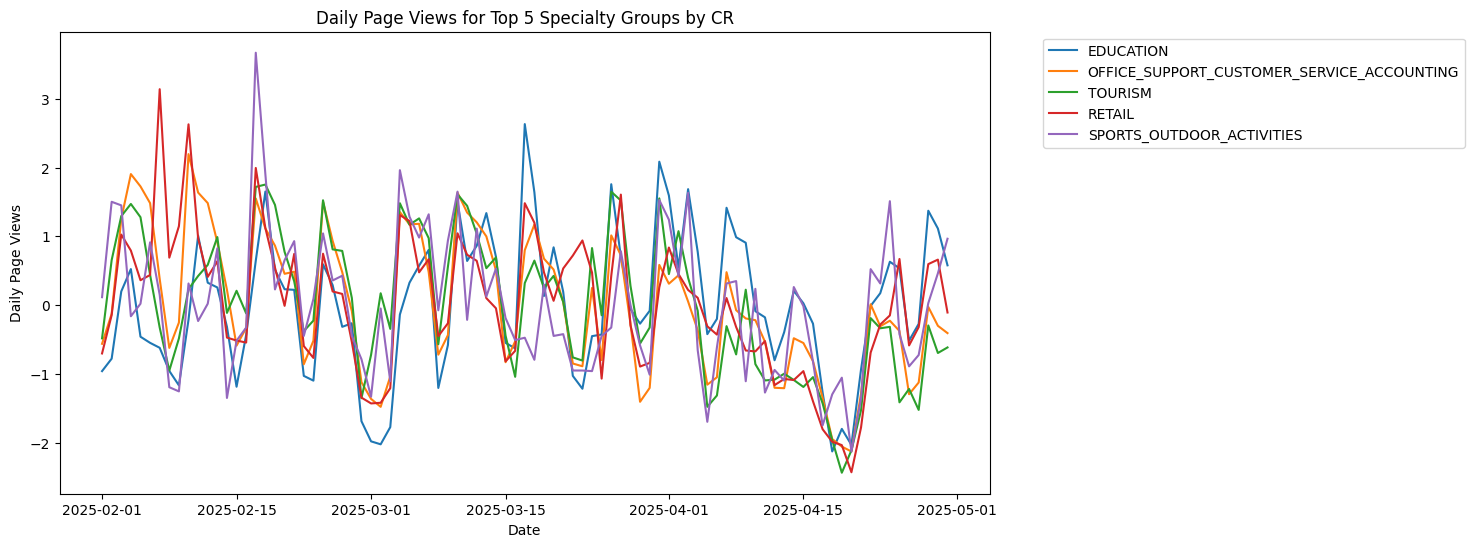

In [0]:
from sklearn.preprocessing import StandardScaler

# Get top 5 groups by conversion rate
top5_specialties = summary.sort_values(by='conversion_rate', ascending=False).head(5)['specialty_group_name']

plt.figure(figsize=(12, 6))

for specialty in top5_specialties:
    subset = daily_pivot[daily_pivot['specialty_group_name'] == specialty].copy()

    # Standardize views
    scaler = StandardScaler()
    subset['standardized_views'] = scaler.fit_transform(subset[['listing_details_page_view']])
                                                                                   
    plt.plot(subset['date'], subset['standardized_views'], label=specialty) 

plt.title("Daily Page Views for Top 5 Specialty Groups by CR")
plt.xlabel("Date")
plt.ylabel("Daily Page Views")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__a)__ Group specialties sorted by __average daily form submissions__.

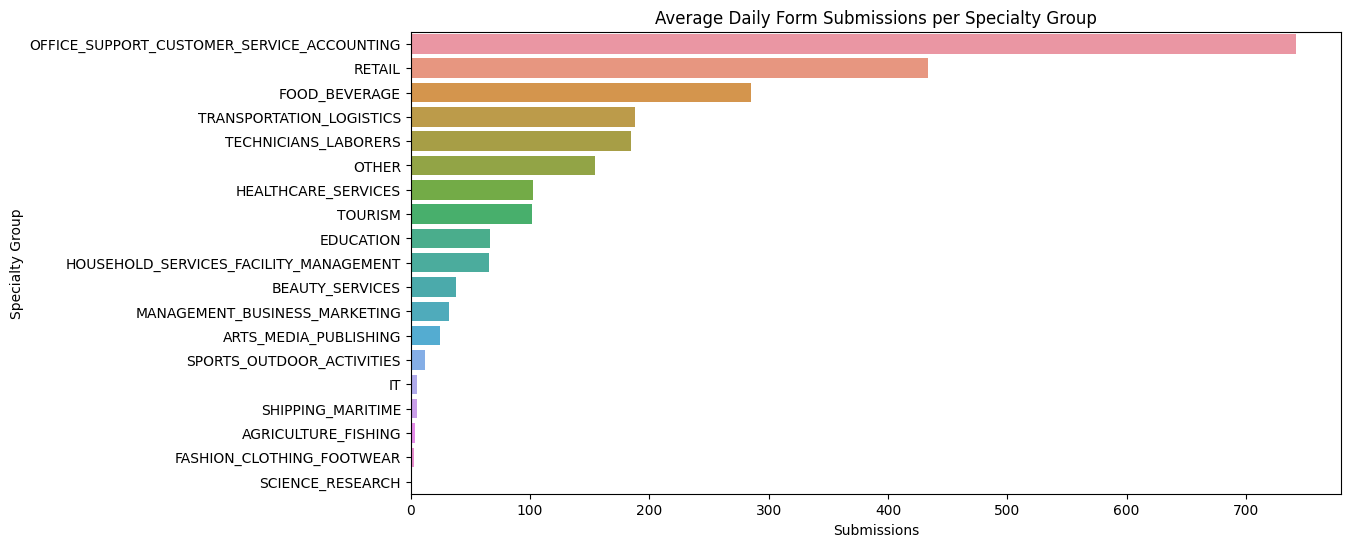

In [0]:
plt.figure(figsize=(12, 6))
sns.barplot(data=summary.sort_values('avg_daily_forms', ascending=False), y='specialty_group_name', x='avg_daily_forms')
plt.title("Average Daily Form Submissions per Specialty Group")
plt.xlabel("Submissions")
plt.ylabel("Specialty Group")
plt.show()

__b)__ Group specialties sorted by __average daily page views__.

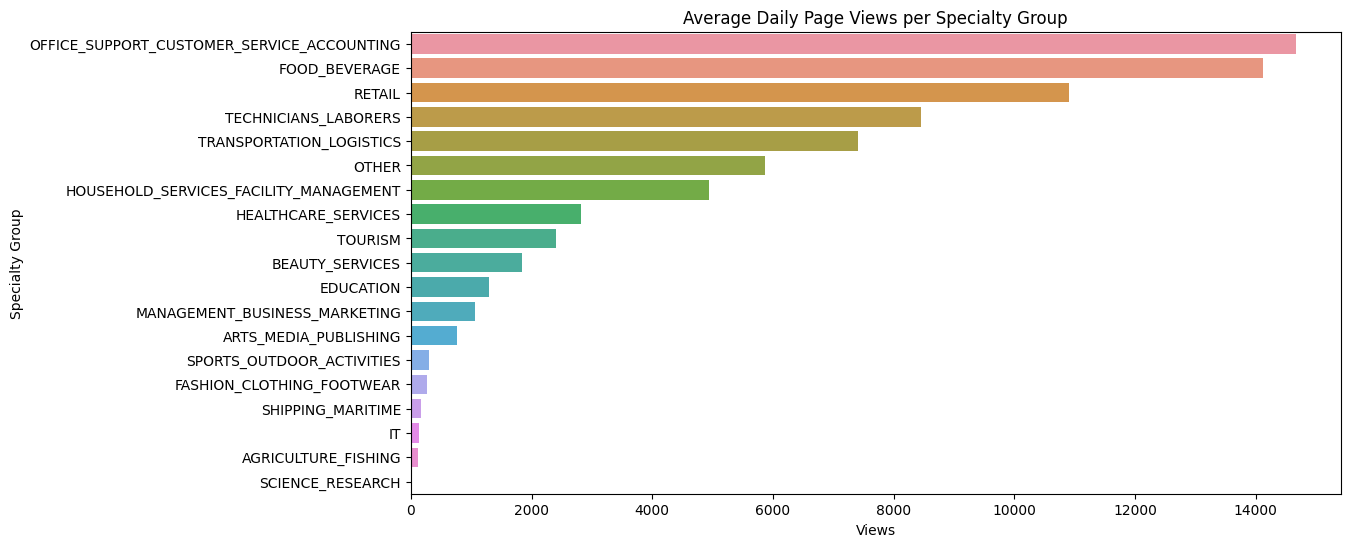

In [0]:
plt.figure(figsize=(12, 6))
sns.barplot(data=summary.sort_values('avg_daily_views', ascending=False), y='specialty_group_name', x='avg_daily_views')
plt.title("Average Daily Page Views per Specialty Group")
plt.xlabel("Views")
plt.ylabel("Specialty Group")
plt.show()

__c)__ Group specialties sorted by __Conversion Rate (CR)__.

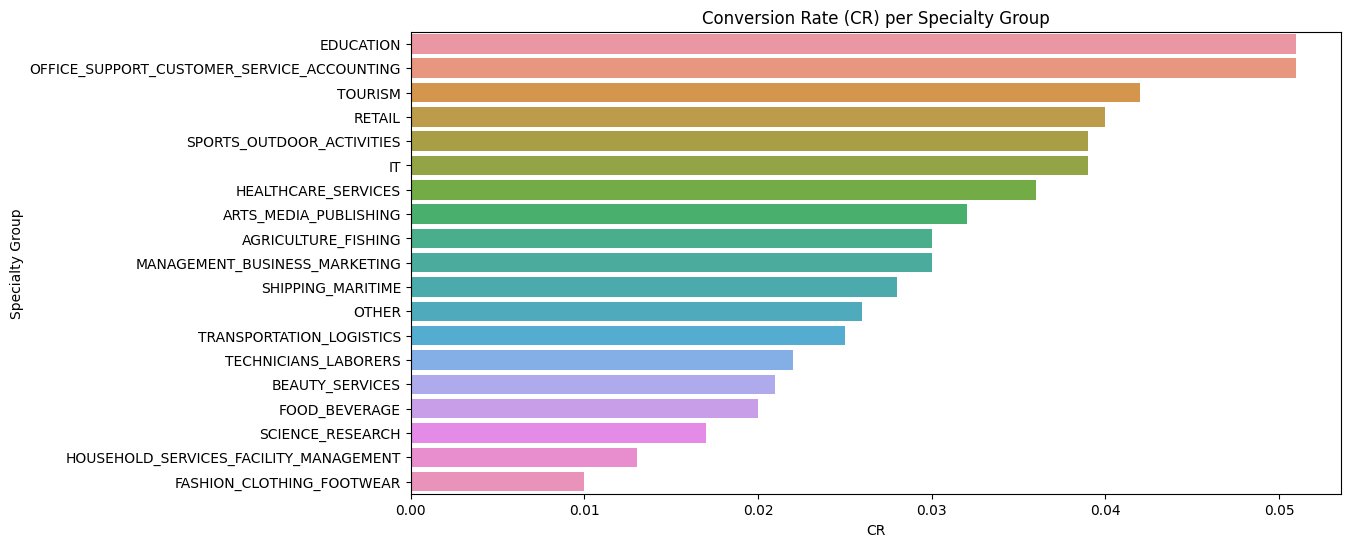

In [0]:
plt.figure(figsize=(12, 6))
sns.barplot(data=summary.sort_values('conversion_rate', ascending=False), y='specialty_group_name', x='conversion_rate')
plt.title("Conversion Rate (CR) per Specialty Group")
plt.xlabel("CR")
plt.ylabel("Specialty Group")
plt.show()

Scatterplot of average daily form submissions with average daily page views per group specialty, colour = CR.

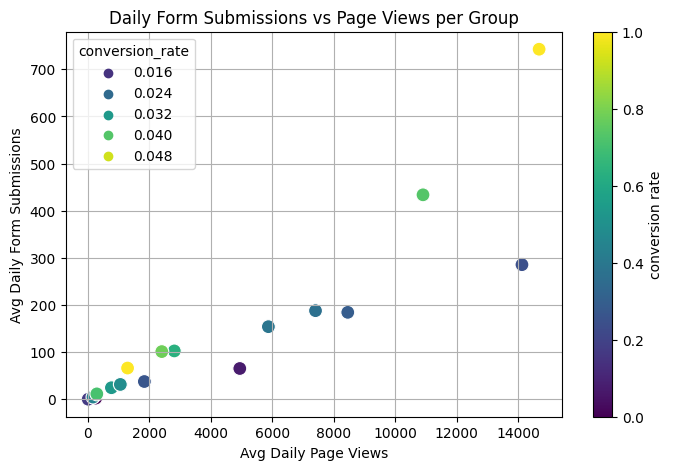

In [0]:
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(data=summary, x='avg_daily_views', y='avg_daily_forms', hue='conversion_rate', palette='viridis', s=100)

plt.title("Daily Form Submissions vs Page Views per Group")
plt.xlabel("Avg Daily Page Views")
plt.ylabel("Avg Daily Form Submissions")
plt.colorbar(scatter.collections[0], label='conversion rate')
plt.grid(True)
plt.show()

Linear correlation of the metrics.

In [0]:
summary.corr()

,avg_daily_views,avg_daily_forms,conversion_rate
avg_daily_views,1.000000,0.893017,0.109110
avg_daily_forms,0.893017,1.000000,0.396672
conversion_rate,0.109110,0.396672,1.000000


__Observations:__  
There is a __strong positive correlation__ between average daily page views and average daily form submissions, meaning that more views generally result in more form submissions. This is expected, as higher exposure naturally leads to more interaction.

However, Conversion Rate (form submissions/views), measures how efficiently a group converts interest into action.

__Exceptions:__  
__Education__ and OFFICE_SUPPORT_CUSTOMER_SERVICE_ACCOUNTING stand out with __high CRs__, despite __Education__ having only moderate page views. This suggests it is highly targeted or appealing, converting better than other high traffic groups.

__Food_Beverage__ and __Retail__, while among the most viewed, show lower CRs, highlighting that popularity doesn't always imply high conversion efficiency. This aligns with the data, where CR shows weak positive correlation with views but moderate positive correlation with form submissions.


#### Question 5
One or more products may be purchased for an ad, for example someone buys 'απλή 14 ημερών’
and when it expires, they buy another product of any type and attach it to the ad. Within each
group specialty, what are the most popular products?

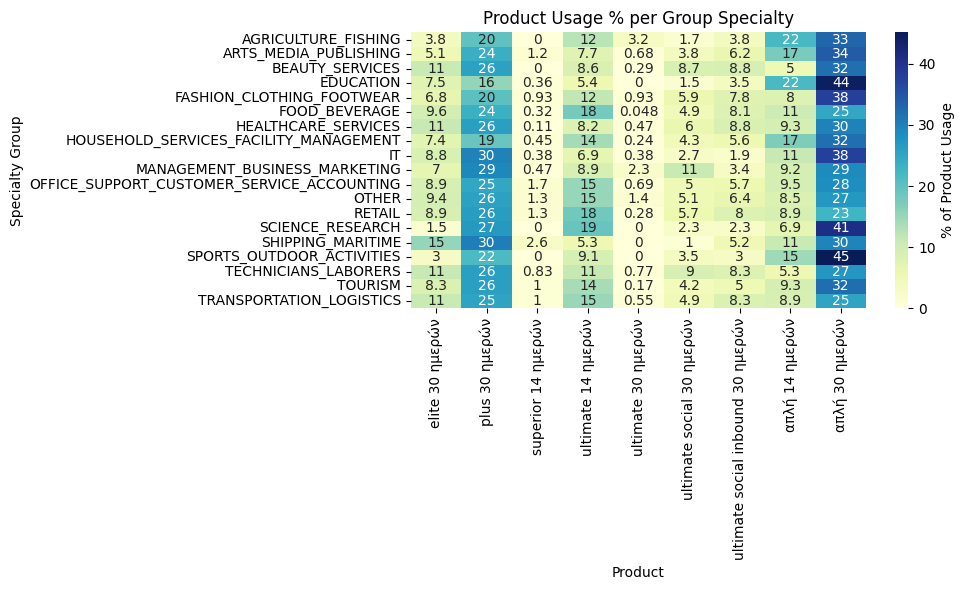

In [0]:
# Merge product data with entries to get group specialty
merged_products = product_purchases.merge(
    entries[['entry_id', 'specialty_group_name']],
    on='entry_id',
    how='inner'
)

# Count product usage per group
product_counts = merged_products.groupby(['specialty_group_name', 'product']).size().reset_index(name='count')

# Convert to percentage within each specialty group
product_pivot = product_counts.pivot_table(index='specialty_group_name', columns='product', values='count', fill_value=0)

# percentage per group
product_percent = product_pivot.div(product_pivot.sum(axis=1), axis=0) * 100

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(product_percent, annot=True, cmap="YlGnBu", cbar_kws={'label': '% of Product Usage'})
plt.title("Product Usage % per Group Specialty")
plt.ylabel("Specialty Group")
plt.xlabel("Product")
plt.tight_layout()
plt.show()


__Observations:__

The heatmap reveals the relative popularity of different products within each specialty group, expressed as percentages of total product usage per group.

- The product __απλή 30 ημερών__ dominates across most group specialties, especially in __AGRICULTURE_FISHING__, __EDUCATION__, __SPORTS_OUTDOOR_ACTIVITIES__, and __FOOD_BEVERAGE__, where it exceeds 30–45% of product usage.
- The product __plus 30 ημερών__ is consistently the second most popular product across many groups, often used in 20-30% of cases.
- Other 'premium products' like __elite 30 ημερών__ and __ultimate__ variants are less common but do appear in several groups.
- Specialty groups like __SCIENCE_RESEARCH__ and __SPORTS_OUTDOOR_ACTIVITIES__ show strong concentration in just four products, indicating low diversity in product choices.
- In contrast, groups like __OTHER__ and __HEALTHCARE_SERVICES__ exhibit more balanced distributions, suggesting varied promotional strategies.

While most group specialties rely heavily on simpler and more affordable products (__απλή__ and __plus__), only a few show significant use of premium options. Among these, __ultimate 14 ημερών__ stands out as the most popular premium product across several specialty groups. 

This trend suggests that many employers opt for short-term promotional visibility during specific periods when employment demand spikes. For example, __Tourism__ in April-May, as the majority of Greece's tourism activity occurs in summer.


#### Question 6
If we assume that supply equals to the total number of unique ads that are uploaded to the
platform and demand equals to the total number of form submission events (unique per visitor
per day), what is the relationship of demand vs supply for each specialty group? Does anything
stand out?

In [0]:
# 1. Supply: Unique ads per group
supply = entries.groupby('specialty_group_name')['entry_id'].nunique().reset_index(name='supply')

# 2. Demand: Unique form submissions per visitor per day per group
form_events = funnel_events[funnel_events['event_name'] == 'listing_message_form_interaction'].copy()

form_events['date'] = pd.to_datetime(form_events['event_date']).dt.date

# Add specialty group
form_events = form_events.merge(entries[['entry_id', 'specialty_group_name']], on='entry_id', how='left')

# Demand: unique (visitor, date) per specialty group
demand = form_events.groupby(['specialty_group_name', 'visitor_id', 'date']).size().reset_index(name='dummy')
demand = demand.groupby('specialty_group_name').size().reset_index(name='demand')

# 3. Merge and calculate demand/supply
demand_supply = pd.merge(supply, demand, on='specialty_group_name', how='inner')
demand_supply['demand_per_supply'] = demand_supply['demand'] / demand_supply['supply']

# Display sorted results
demand_supply.sort_values(by='demand_per_supply', ascending=False, inplace=True)
display(demand_supply)


specialty_group_name,supply,demand,demand_per_supply
OFFICE_SUPPORT_CUSTOMER_SERVICE_ACCOUNTING,3921,9380,2.3922468757969906
TOURISM,822,1370,1.6666666666666667
EDUCATION,662,975,1.472809667673716
HEALTHCARE_SERVICES,1021,1326,1.2987267384916747
RETAIL,3316,4273,1.2886007237635706
ARTS_MEDIA_PUBLISHING,354,396,1.11864406779661
OTHER,1883,1949,1.0350504514073287
TRANSPORTATION_LOGISTICS,2201,2240,1.0177192185370285
IT,105,99,0.9428571428571428
AGRICULTURE_FISHING,71,64,0.9014084507042254


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

__Observations:__
By comparing demand (unique form submissions) with supply (number of unique job ads), we observe large differences in demand pressure across job specialties.

- __OFFICE_SUPPORT_CUSTOMER_SERVICE_ACCOUNTING__, __Tourism__, and __Education__ stand out with high __demand-to-supply ratios__ (above 1.4), suggesting stronger interest per available ad.
- On the other hand, specialty groups like __Food & Beverage__, __Technicians_Laborers__, and __Fashion__ have low ratios (below 0.6), indicating potential oversupply or lower candidate engagement.

This highlights how some job markets (e.g. Tourism, Education) may be more competitive or seasonally intense (the data cover the period from February to April 2025), while others might reflect market saturation.
